# Practice 1. Cross Validation

Do together

In [1]:
import gc
import os
import math
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_auc_score, roc_curve
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import lightgbm as lgb
import time
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
import seaborn as sns

## Quick Data Treatment

In [2]:
df = pd.read_csv('data/ufc.csv')
df.head()

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,no_of_rounds,B_current_lose_streak,...,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Henry Cejudo,Marlon Moraes,Marc Goddard,2019-06-08,"Chicago, Illinois, USA",Red,True,Bantamweight,5,0.0,...,2.0,0.0,0.0,8.0,Orthodox,162.56,162.56,135.0,31.0,32.0
1,Valentina Shevchenko,Jessica Eye,Robert Madrigal,2019-06-08,"Chicago, Illinois, USA",Red,True,Women's Flyweight,5,0.0,...,0.0,2.0,0.0,5.0,Southpaw,165.10,167.64,125.0,32.0,31.0
2,Tony Ferguson,Donald Cerrone,Dan Miragliotta,2019-06-08,"Chicago, Illinois, USA",Red,False,Lightweight,3,0.0,...,3.0,6.0,1.0,14.0,Orthodox,180.34,193.04,155.0,36.0,35.0
3,Jimmie Rivera,Petr Yan,Kevin MacDonald,2019-06-08,"Chicago, Illinois, USA",Blue,False,Bantamweight,3,0.0,...,1.0,0.0,0.0,6.0,Orthodox,162.56,172.72,135.0,26.0,29.0
4,Tai Tuivasa,Blagoy Ivanov,Dan Miragliotta,2019-06-08,"Chicago, Illinois, USA",Blue,False,Heavyweight,3,0.0,...,2.0,0.0,0.0,3.0,Southpaw,187.96,190.50,264.0,32.0,26.0


In [3]:
df = df[df.Winner != "Draw"]
df['Winner'] = df.Winner.replace('Red',1).replace('Blue',0)
df.fillna(value=0,inplace=True)

In [4]:
y = df['Winner']
X = df.copy()
X = X.drop(columns = ['R_fighter',
                     'B_fighter',
                     'Referee',
                     'date',
                     'location',
                     'Winner',
                     'title_bout',
                     'weight_class',
                      'R_Stance',
                      'B_Stance'
                     ])

In [5]:
df.head()

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,no_of_rounds,B_current_lose_streak,...,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Henry Cejudo,Marlon Moraes,Marc Goddard,2019-06-08,"Chicago, Illinois, USA",1,True,Bantamweight,5,0.0,...,2.0,0.0,0.0,8.0,Orthodox,162.56,162.56,135.0,31.0,32.0
1,Valentina Shevchenko,Jessica Eye,Robert Madrigal,2019-06-08,"Chicago, Illinois, USA",1,True,Women's Flyweight,5,0.0,...,0.0,2.0,0.0,5.0,Southpaw,165.10,167.64,125.0,32.0,31.0
2,Tony Ferguson,Donald Cerrone,Dan Miragliotta,2019-06-08,"Chicago, Illinois, USA",1,False,Lightweight,3,0.0,...,3.0,6.0,1.0,14.0,Orthodox,180.34,193.04,155.0,36.0,35.0
3,Jimmie Rivera,Petr Yan,Kevin MacDonald,2019-06-08,"Chicago, Illinois, USA",0,False,Bantamweight,3,0.0,...,1.0,0.0,0.0,6.0,Orthodox,162.56,172.72,135.0,26.0,29.0
4,Tai Tuivasa,Blagoy Ivanov,Dan Miragliotta,2019-06-08,"Chicago, Illinois, USA",0,False,Heavyweight,3,0.0,...,2.0,0.0,0.0,3.0,Southpaw,187.96,190.50,264.0,32.0,26.0


### Data cleaning

## Split Data and normalize

Normalize the data X (optional)

In [6]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)

In [7]:
X_scaled_train, X_scaled_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=20)

In [8]:
X_scaled_train.shape, X_scaled_test.shape

((4048, 135), (1013, 135))

## Train with Train/test split

This function is to show which featuree is important

In [9]:
params = {
          'n_estimators': 5000,
          'num_leaves': 6,
          'min_data_in_leaf': 2,
          'max_depth': -1,
          'learning_rate': 0.02,
          "boosting": "gbdt",
          "bagging_freq": 10,
          'num_threads': 8,
          "bagging_fraction": 0.7,
          "bagging_seed": 11,
          "metric": 'binary_logloss',
         }

In [10]:
def plot_feature_importance(feature_importance,title):
    fe = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)
    fe['feature'] = fe.index
    plt.figure(figsize=(16, 12))
    sns.barplot(x="importance", y="feature", data=fe[:50])
    plt.xticks([])
    plt.title(title)
    return

In [11]:
def train_lgb(X_train, X_valid, y_train, y_valid, params=None):

    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=['auc', 'binary_logloss'],
            verbose=0, early_stopping_rounds=50)

    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)
    
    print('Train AUC:',roc_auc_score(y_train, y_pred_train))
    print('Valid AUC:',roc_auc_score(y_valid, y_pred_valid))
        
    importance = pd.DataFrame()
    importance["feature"] = X.columns
    importance["importance"] = model.feature_importances_
    return y_pred_train, y_pred_valid, importance, model

In [12]:
y_pred_train, y_pred_valid, importance, _ = train_lgb(X_scaled_train, X_scaled_test, y_train, y_test, params)

Train AUC: 0.6141219454756235
Valid AUC: 0.5719684850423932


## Train with Cross-Validation

In [13]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=100)
# Shuffle sould be true
# But if time series, for example, don't shuffle
# Kfold: split into k fold randomly
# StratifiedFold : idem, butnumber of each classes are well distributed between folds

# When data is unbalanced --> always Stratfold

In [14]:
def train_fold_lgb(X, y, params=None,folds=folds):
    oof = np.zeros(len(X))
    all_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Train Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        print('Fold sizes: ', X_train.shape, X_valid.shape)
        
        y_pred_train, y_pred_valid, fold_importance, lgb_model = train_lgb(X_train, X_valid, y_train, y_valid, params)

        # Save model in file
        filename = f"lgb_{fold_n}.txt"
        lgb_model.booster_.save_model(filename)
        
        print("Model saved in ", filename)
        
        # Add Fold prediction to Out-Of-Fold Prediction
        oof[valid_index] = y_pred_valid.reshape(-1,)
        
        # Add Fold importance to overal importance
        fold_importance["fold"] = fold_n + 1
        all_importance = pd.concat([all_importance, fold_importance], axis=0)
        print('====================================')
    print('Final result of Out-Of-Fold:')
    print('OOF AUC:',roc_auc_score(y, oof))
        
    return oof, all_importance

In [15]:
oof, feature_importance = train_fold_lgb(X_scaled_train, y_train, params=params)

Train Fold 0 started at Thu Apr 16 10:36:15 2020
Fold sizes:  (3238, 135) (810, 135)
Train AUC: 0.5498996285923718
Valid AUC: 0.5355682833641756
Model saved in  lgb_0.txt
Train Fold 1 started at Thu Apr 16 10:36:16 2020
Fold sizes:  (3238, 135) (810, 135)
Train AUC: 0.5803248677134945
Valid AUC: 0.5370895068553737
Model saved in  lgb_1.txt
Train Fold 2 started at Thu Apr 16 10:36:17 2020
Fold sizes:  (3238, 135) (810, 135)
Train AUC: 0.5100891166215331
Valid AUC: 0.5032149684295893
Model saved in  lgb_2.txt
Train Fold 3 started at Thu Apr 16 10:36:19 2020
Fold sizes:  (3239, 135) (809, 135)
Train AUC: 0.6307909674485996
Valid AUC: 0.5441933845930654
Model saved in  lgb_3.txt
Train Fold 4 started at Thu Apr 16 10:36:20 2020
Fold sizes:  (3239, 135) (809, 135)
Train AUC: 0.6377830844551939
Valid AUC: 0.5701352296905567
Model saved in  lgb_4.txt
Final result of Out-Of-Fold:
OOF AUC: 0.5380726931010041


Plot the feature importance

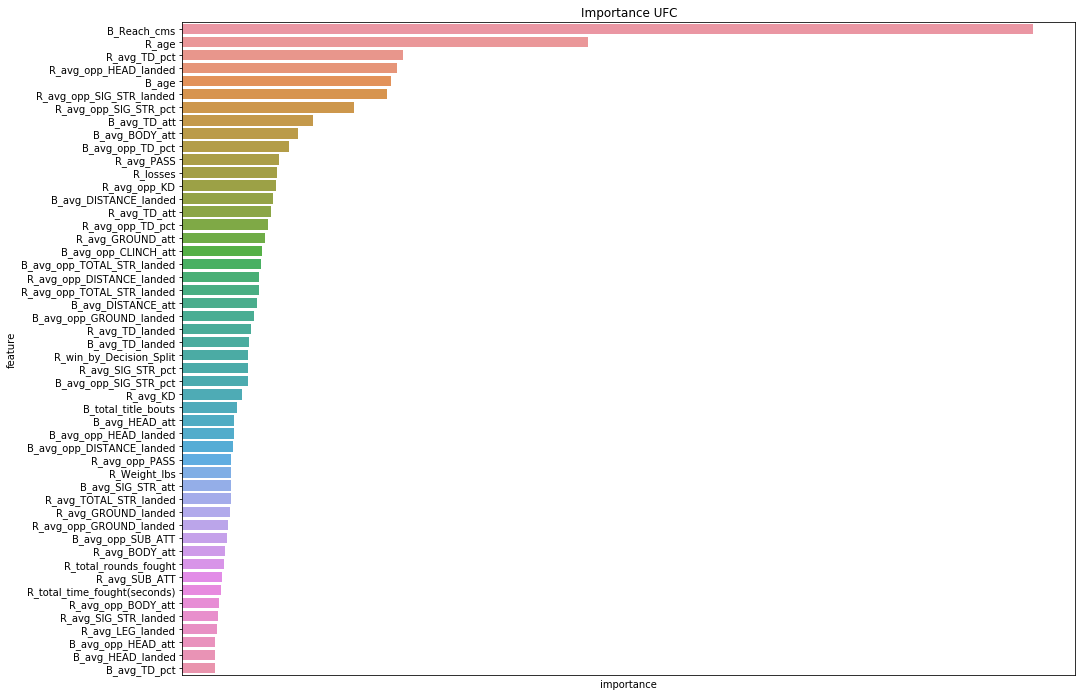

In [16]:
plot_feature_importance(feature_importance, title = 'Importance UFC')

In [17]:
# Ordering important features
feature_importance = feature_importance.sort_values(by=['importance'], ascending=False)

In [25]:
# Get important columns
important_columns = feature_importance["feature"].unique()[:10]
# important_columns = np.append(important_columns, "Winner")

In [26]:
# Create dataset for 3B
small_df_for_the_exercise_3B = df[important_columns].head(1000)
small_df_for_the_exercise_3B.to_csv('small_ufc.csv', index=False)

## Other models

#### Neural network

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization


Using TensorFlow backend.


In [18]:
def train_nn(X_train, X_valid, y_train, y_valid):
    
    
    # Create a model
    model = Sequential()
    model.add(Dense(20, input_dim=X_train.shape[1], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'],
             )
    
    # Train model and predict on valid

    model.fit(X_train, y_train,
              epochs=200,
              batch_size=32,
              verbose=0)

    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)
    
    # Print acc
    print('Train AUC:',roc_auc_score(y_train, y_pred_train))
    print('Valid AUC:',roc_auc_score(y_valid, y_pred_valid))
        
    return y_pred_train, y_pred_valid, model

In [19]:
_, _, _ = train_nn(X_scaled_train, X_scaled_test, y_train, y_test)

Train AUC: 0.94954367718147
Valid AUC: 0.6795757123304715


In [20]:
def train_fold_nn(X, y, folds=folds):
    oof = np.zeros(len(X))
    
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Train Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        print('Fold sizes: ', X_train.shape, X_valid.shape)
        
        y_pred_train, y_pred_valid, nn_model = train_nn(X_train, X_valid, y_train, y_valid)
        
        # Save model in file
        
        filename = f"nn_{fold_n}.txt"
        nn_model.save(filename)
        print('Model saved in ', filename)
        
        # Add Fold prediction to Out-Of-Fold Prediction
        oof[valid_index] = y_pred_valid.reshape(-1,)
        
        print('====================================')
    print('Final result of Out-Of-Fold:')
    print('OOF AUC:',roc_auc_score(y, oof))
        
    return oof

In [21]:
oof = train_fold_nn(X_scaled_train, y_train)

Train Fold 0 started at Wed Apr 15 09:05:13 2020
Fold sizes:  (3238, 135) (810, 135)
Train AUC: 0.9708065137812951
Valid AUC: 0.6966247071157675
Model saved in  nn_0.txt
Train Fold 1 started at Wed Apr 15 09:05:41 2020
Fold sizes:  (3238, 135) (810, 135)
Train AUC: 0.9672452074130599
Valid AUC: 0.6874170720919947
Model saved in  nn_1.txt
Train Fold 2 started at Wed Apr 15 09:06:08 2020
Fold sizes:  (3238, 135) (810, 135)
Train AUC: 0.9502522168533956
Valid AUC: 0.6926881190986502
Model saved in  nn_2.txt
Train Fold 3 started at Wed Apr 15 09:06:35 2020
Fold sizes:  (3239, 135) (809, 135)
Train AUC: 0.9700633973439812
Valid AUC: 0.6816625562164514
Model saved in  nn_3.txt
Train Fold 4 started at Wed Apr 15 09:07:01 2020
Fold sizes:  (3239, 135) (809, 135)
Train AUC: 0.9597342162602751
Valid AUC: 0.6679304288223451
Model saved in  nn_4.txt
Final result of Out-Of-Fold:
OOF AUC: 0.6839317427071969


In [22]:
test_pred = []
for i in range (n_fold):
    print("Test fold : ", i)
    model = lgb.Booster(model_file = "lgb_" + str(i) + ".txt")
    y_pred_test = model.predict(X_scaled_test)
    print("Test AUC : ", roc_auc_score(y_test, y_pred_test))
    test_pred.append(y_pred_test)

Test fold :  0
Test AUC :  0.6992481203007519
Test fold :  1
Test AUC :  0.6958664391475141
Test fold :  2
Test AUC :  0.7012233598179847
Test fold :  3
Test AUC :  0.710284132316607
Test fold :  4
Test AUC :  0.710637409125651


In [23]:
z = np.array(test_pred)

In [24]:
final_test = np.mean(z, axis = 0)

In [25]:
print("Final test AUC: ", roc_auc_score(y_test, final_test))

Final test AUC:  0.7116261398176292


In [26]:
from keras.models import load_model

In [27]:
test_pred = []
for i in range (n_fold):
    print("Test fold : ", i)
    model = load_model("nn_" + str(i) + ".txt")
    y_pred_test = model.predict(X_scaled_test)
    print("Test AUC : ", roc_auc_score(y_test, y_pred_test))
    test_pred.append(y_pred_test)

Test fold :  0
Test AUC :  0.6464387920154997
Test fold :  1
Test AUC :  0.6716036545263869
Test fold :  2
Test AUC :  0.6673687765513072
Test fold :  3
Test AUC :  0.6898451803267033
Test fold :  4
Test AUC :  0.6987593096215716


In [28]:
z = np.array(test_pred)

In [29]:
final_test = np.mean(z, axis = 0)

In [30]:
print("Final test AUC: ", roc_auc_score(y_test, final_test))

Final test AUC:  0.7072735029062016


### Sklearn models

#### Linear model

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.externals import joblib

In [32]:
def train_linear(X_train, X_valid, y_train, y_valid):
    
    
    # Create a model
    model = LinearRegression()
    
    # Train model and predict on valid

    model.fit(X_train, y_train,)

    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)
    
    # Print acc
    print('Train AUC:',roc_auc_score(y_train, y_pred_train))
    print('Valid AUC:',roc_auc_score(y_valid, y_pred_valid))
        
    return y_pred_train, y_pred_valid, model

In [33]:
_, _, _ = train_linear(X_scaled_train, X_scaled_test, y_train, y_test)

Train AUC: 0.7649095602531562
Valid AUC: 0.7128770507829858


In [34]:
def train_fold_linear(X, y, folds=folds):
    oof = np.zeros(len(X))
    
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Train Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        print('Fold sizes: ', X_train.shape, X_valid.shape)
        
        y_pred_train, y_pred_valid, linear_model = train_linear(X_train, X_valid, y_train, y_valid)
        
        # Save model in file
        filename = f"linear_{fold_n}.txt"
        joblib.dump(linear_model, filename) 
        print("Model saved in ", filename)
        
        # Add Fold prediction to Out-Of-Fold Prediction
        oof[valid_index] = y_pred_valid.reshape(-1,)
        
        print('====================================')
    print('Final result of Out-Of-Fold:')
    print('OOF AUC:',roc_auc_score(y, oof))
        
    return oof

In [35]:
oof = train_fold_linear(X_scaled_train, y_train)

Train Fold 0 started at Wed Apr 15 09:07:38 2020
Fold sizes:  (3238, 135) (810, 135)
Train AUC: 0.7657859381997313
Valid AUC: 0.7275349877920927
Model saved in  linear_0.txt
Train Fold 1 started at Wed Apr 15 09:07:38 2020
Fold sizes:  (3238, 135) (810, 135)
Train AUC: 0.7689468847737068
Valid AUC: 0.7293716828836798
Model saved in  linear_1.txt
Train Fold 2 started at Wed Apr 15 09:07:38 2020
Fold sizes:  (3238, 135) (810, 135)
Train AUC: 0.7734570523372095
Valid AUC: 0.7083212651335227
Model saved in  linear_2.txt
Train Fold 3 started at Wed Apr 15 09:07:38 2020
Fold sizes:  (3239, 135) (809, 135)
Train AUC: 0.7740981999824854
Valid AUC: 0.7054620629624255
Model saved in  linear_3.txt
Train Fold 4 started at Wed Apr 15 09:07:38 2020
Fold sizes:  (3239, 135) (809, 135)
Train AUC: 0.7641899607015823
Valid AUC: 0.7425637949992145
Model saved in  linear_4.txt
Final result of Out-Of-Fold:
OOF AUC: 0.7226479351705324


In [36]:
test_pred = []
for i in range (n_fold):
    print("Test fold : ", i)
    model = joblib.load("linear_" + str(i) + ".txt")
    y_pred_test = model.predict(X_scaled_test)
    print("Test AUC : ", roc_auc_score(y_test, y_pred_test))
    test_pred.append(y_pred_test)

Test fold :  0
Test AUC :  0.6915382427700457
Test fold :  1
Test AUC :  0.7146367692280345
Test fold :  2
Test AUC :  0.7186094669297357
Test fold :  3
Test AUC :  0.708633285341012
Test fold :  4
Test AUC :  0.7108418208642172


In [37]:
z = np.array(test_pred)
final_test = np.mean(z, axis = 0)
print("Final test AUC: ", roc_auc_score(y_test, final_test))

Final test AUC:  0.712841500915409


#### SVM

In [38]:
from sklearn.svm import SVC

In [39]:
def train_svc(X_train, X_valid, y_train, y_valid):
    
    
    # Create a model
    model = SVC()
    
    # Train model and predict on valid

    model.fit(X_train, y_train,)

    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)
    
    # Print acc
    print('Train AUC:',roc_auc_score(y_train, y_pred_train))
    print('Valid AUC:',roc_auc_score(y_valid, y_pred_valid))
        
    return y_pred_train, y_pred_valid, model

In [40]:
_, _, _ = train_svc(X_scaled_train, X_scaled_test, y_train, y_test)

Train AUC: 0.6755491858204311
Valid AUC: 0.5642541637782399


In [41]:
def train_fold_svc(X, y, folds=folds):
    oof = np.zeros(len(X))
    
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Train Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        print('Fold sizes: ', X_train.shape, X_valid.shape)
        
        y_pred_train, y_pred_valid, linear_model = train_svc(X_train, X_valid, y_train, y_valid)
        
        # Save model in file
        filename = f"svc_{fold_n}.txt"
        joblib.dump(linear_model, filename) 
        print("Model saved in ", filename)
        
        # Add Fold prediction to Out-Of-Fold Prediction
        oof[valid_index] = y_pred_valid.reshape(-1,)
        
        print('====================================')
    print('Final result of Out-Of-Fold:')
    print('OOF AUC:',roc_auc_score(y, oof))
        
    return oof

In [44]:
oof = train_fold_svc(X_scaled_train, y_train)

Train Fold 0 started at Wed Apr 15 09:12:09 2020
Fold sizes:  (3238, 135) (810, 135)
Train AUC: 0.6589542212805208
Valid AUC: 0.5509143617058703
Model saved in  svc_0.txt
Train Fold 1 started at Wed Apr 15 09:12:13 2020
Fold sizes:  (3238, 135) (810, 135)
Train AUC: 0.6752612591310827
Valid AUC: 0.549452675807165
Model saved in  svc_1.txt
Train Fold 2 started at Wed Apr 15 09:12:17 2020
Fold sizes:  (3238, 135) (810, 135)
Train AUC: 0.6816421529584594
Valid AUC: 0.5449371488153856
Model saved in  svc_2.txt
Train Fold 3 started at Wed Apr 15 09:12:21 2020
Fold sizes:  (3239, 135) (809, 135)
Train AUC: 0.6931274873085895
Valid AUC: 0.5603547076744523
Model saved in  svc_3.txt
Train Fold 4 started at Wed Apr 15 09:12:26 2020
Fold sizes:  (3239, 135) (809, 135)
Train AUC: 0.669243572053906
Valid AUC: 0.5381591911922203
Model saved in  svc_4.txt
Final result of Out-Of-Fold:
OOF AUC: 0.5486414413020502


In [45]:
test_pred = []
for i in range (n_fold):
    print("Test fold : ", i)
    model = joblib.load("svc_" + str(i) + ".txt")
    y_pred_test = model.predict(X_scaled_test)
    print("Test AUC : ", roc_auc_score(y_test, y_pred_test))
    test_pred.append(y_pred_test)

Test fold :  0
Test AUC :  0.5391492916688885
Test fold :  1
Test AUC :  0.5603103503439449
Test fold :  2
Test AUC :  0.5666204518388169
Test fold :  3
Test AUC :  0.5694866599121918
Test fold :  4
Test AUC :  0.555866616896852


In [46]:
z = np.array(test_pred)
final_test = np.mean(z, axis = 0)
print("Final test AUC: ", roc_auc_score(y_test, final_test))

Final test AUC:  0.589341260953803
